In [1]:
# This notebook extracts daily SST time-series from the ESA-CCI L4 analysis dataset v2.1 available here
# https://data.ceda.ac.uk/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1
# The time series are extracted on an area that is 0.2 deg wide.
# Daily data are converted to monthly data and then some temporal stats are computed.

# From the daily data I can compute a single annual file with the monthly means with
#     cdo -monmean -cat '2010*nc' monthly_2010.nc
# NB: I recursively link the daily files in the same (annual) folder with 
#     ln -r -s */*/*1-v* . 

# For Chl-a I download data from https://catalogue.ceda.ac.uk/uuid/e9f82908fd9c48138b31e5cfaa6d692b with
#     wget -e robots=off --mirror --no-parent -r https://dap.ceda.ac.uk/neodc/esacci/ocean_colour/data/v5.0-release/geographic/netcdf/chlor_a/monthly/v5.0/2008/ 
# being in /media/agostino/sailboat (and selecting the various years).
# ESA CCI Ocean Color dataset (L3 Chl-a on a geographical projection on a monthly basis at 4 km grid spacing).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob

In [2]:
def plot_background(ax):
    #ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [3]:
# Read the file with the location of the sediments

filename = 'DB_27122022.csv'
df_loc = pd.read_csv(filename,sep='\t')
df_loc

,LAT,LONG,Water depth,Stations/Facies
0,-16.50,-151.80,10.0,BB14
1,-16.50,-151.80,0.5,BB19
2,-16.50,-151.80,3.0,BB28
3,-16.50,-151.80,13.0,BB1
4,-16.50,-151.80,22.0,BB2
...,...,...,...,...
2259,-26.07,32.95,2.5,T6Pontatorres_3
2260,-26.07,32.95,5.0,T6Pontatorres_4
2261,-26.07,32.95,6.5,T6Pontatorres_5
2262,-26.07,32.95,7.0,T6Pontatorres_6


In [4]:
# Set the path to SST files
path2sst = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/'
path2chla = '/media/agostino/sailboat/dap.ceda.ac.uk/neodc/esacci/ocean_colour/data/v5.0-release/geographic/netcdf/chlor_a/monthly/v5.0/'

# Set the time window in which data are available at the monthly res.
str_start = '2007-01-01' #'YYYY-MM-DD'
str_end = '2013-12-01'
instant_start = np.datetime64(str_start)
instant_end = np.datetime64(str_end)

# Set the half width of the box over which to take the average.
dlat = 0.1
dlon = 0.1

In [20]:
allstats_db = np.array(['LONG','LAT','Water depth','Stations/Facies',
                        'SSTmin_K','SSTavg_K','SSTmax_K',
                        'SSTJan_K','SSTFeb_K','SSTMar_K','SSTApr_K','SSTMay_K','SSTJun_K',
                        'SSTJul_K','SSTAug_K','SSTSep_K','SSTOct_K','SSTNov_K','SSTDec_K',
                        'Chlamin_mg_m-3','Chlaavg_mg_m-3','Chlamax_mg_m-3',
                        'ChlaJan_mg_m-3','ChlaFeb_mg_m-3','ChlaMar_mg_m-3','ChlaApr_mg_m-3','ChlaMay_mg_m-3','ChlaJun_mg_m-3',
                        'ChlaJul_mg_m-3','ChlaAug_mg_m-3','ChlaSep_mg_m-3','ChlaOct_mg_m-3','ChlaNov_mg_m-3','ChlaDec_mg_m-3'
                       ])


for ss in range(5):#range(len(df_loc['LONG'])): # Loop on the sites.
    # Select the point.
    lon0 = df_loc['LONG'][ss]
    lat0 = df_loc['LAT'][ss]
    wd0 = df_loc['Water depth'][ss]
    sf0 = str(df_loc['Stations/Facies'][ss])
    
    print('--------------------------------------------')
    print(sf0)
    print(wd0)
    print(sf0 + ' at ' + str(wd0) +' m')
    print(str(ss) +' out of '+ str(len(df_loc['LONG'])))
    print('--------------------------------------------')

    # Time loop
    instant = instant_start
    it_s_the_first_instant = True
    time_series = []
    sst_series = []
    chla_series = []
    sst_seasonal = np.zeros(12) # To compute the seasonal cycle
    sst_seasonal_count = np.zeros(12)
    chla_seasonal = np.zeros(12)
    chla_seasonal_count = np.zeros(12)
    nyears = 0 # Number of years.

    while instant <= instant_end:
        print(instant)
        pd_instant = pd.to_datetime(instant)
        year_oi = str(pd_instant.year).zfill(4)

        # Read the annual SST file.
        path_sst_oi = path2sst + '/' +  year_oi + '/'
        filename_sst = 'monthly_'+year_oi+'.nc'
        ds_sst = xr.open_dataset(path_sst_oi + filename_sst)

        # Set the path of the monthly Chla data for the current year.
        path_chla_oi = path2chla + '/' +  year_oi + '/'

        for mm in range(12):
            # Define the monthly time step in the time_series.
            month_oi = str(mm+1).zfill(2)
            time_series.extend([year_oi + '-' + month_oi])
            
            # Read the pointwise SST value.
            sst0 = ds_sst['analysed_sst'][mm].sel(lon=slice(lon0-dlon,lon0+dlon),
                                                  lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

            sst_series.extend([sst0.item()])
            sst_seasonal[mm] += sst0
            sst_seasonal_count[mm] += 1
            #print(sst_series)
            
            # Read the Chl-a data.
            filename_chla = 'ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-'+year_oi+month_oi+'-fv5.0.nc'
            ds_chla = xr.open_dataset(path_chla_oi + filename_chla)

            chla0 = ds_chla['chlor_a'][0].sel(lon=slice(lon0-dlon,lon0+dlon),
                                              lat=slice(lat0+dlat,lat0-dlat)).mean(dim=['lon','lat'],skipna=True).values
            chla_series.extend([chla0.item()])
            chla_seasonal[mm] += chla0
            chla_seasonal_count[mm] += 1

            if it_s_the_first_instant:
                # Check the position of the point on a map.
                crs = ccrs.PlateCarree()
                lon_sst = ds_sst['lon'].values
                lat_sst = ds_sst['lat'].values
                l4_sst = ds_sst['analysed_sst'].values
                lon_chla = ds_chla['lon'].values
                lat_chla = ds_chla['lat'].values
                chla_map = ds_chla['chlor_a'].values

                it_s_the_first_instant = False
                
        instant = np.datetime64(str(int(year_oi)+1)+'-01-01') #+= np.timedelta64(1,'Y')
        nyears += 1

    # Compute the statistics of interest for SST and Chla.
    sst_t = np.array(sst_series)
    sst_min = np.min(sst_t)
    sst_max = np.max(sst_t)
    sst_avg = np.mean(sst_t)
    sst_seasonal_cycle = sst_seasonal/sst_seasonal_count 
    sst_stats = np.concatenate((np.array([lon0,lat0,wd0,sf0,sst_min,sst_avg,sst_max]),sst_seasonal_cycle))
    
    chla_t = np.array(chla_series)
    chla_min = np.min(chla_t)
    chla_max = np.max(chla_t)
    chla_avg = np.mean(chla_t)
    chla_seasonal_cycle = chla_seasonal/chla_seasonal_count 
    chla_stats = np.concatenate((np.array([chla_min,chla_avg,chla_max]),chla_seasonal_cycle))
    
    allstats_db = np.vstack([allstats_db,np.concatenate([sst_stats,chla_stats])])
    
    print(allstats_db)
    
#pd.DataFrame(allstats_db).to_csv('stats_prova.csv')


--------------------------------------------
BB14
10.0
BB14 at 10.0 m
0 out of 2264
--------------------------------------------
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
[['LONG' 'LAT' 'Water depth' 'Stations/Facies' 'SSTmin_K' 'SSTavg_K'
  'SSTmax_K' 'SSTJan_K' 'SSTFeb_K' 'SSTMar_K' 'SSTApr_K' 'SSTMay_K'
  'SSTJun_K' 'SSTJul_K' 'SSTAug_K' 'SSTSep_K' 'SSTOct_K' 'SSTNov_K'
  'SSTDec_K' 'Chlamin_mg_m-3' 'Chlaavg_mg_m-3' 'Chlamax_mg_m-3'
  'ChlaJan_mg_m-3' 'ChlaFeb_mg_m-3' 'ChlaMar_mg_m-3' 'ChlaApr_mg_m-3'
  'ChlaMay_mg_m-3' 'ChlaJun_mg_m-3' 'ChlaJul_mg_m-3' 'ChlaAug_mg_m-3'
  'ChlaSep_mg_m-3' 'ChlaOct_mg_m-3' 'ChlaNov_mg_m-3' 'ChlaDec_mg_m-3']
 ['-151.8' '-16.5' '10.0' 'BB14' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.9

2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
[['LONG' 'LAT' 'Water depth' 'Stations/Facies' 'SSTmin_K' 'SSTavg_K'
  'SSTmax_K' 'SSTJan_K' 'SSTFeb_K' 'SSTMar_K' 'SSTApr_K' 'SSTMay_K'
  'SSTJun_K' 'SSTJul_K' 'SSTAug_K' 'SSTSep_K' 'SSTOct_K' 'SSTNov_K'
  'SSTDec_K' 'Chlamin_mg_m-3' 'Chlaavg_mg_m-3' 'Chlamax_mg_m-3'
  'ChlaJan_mg_m-3' 'ChlaFeb_mg_m-3' 'ChlaMar_mg_m-3' 'ChlaApr_mg_m-3'
  'ChlaMay_mg_m-3' 'ChlaJun_mg_m-3' 'ChlaJul_mg_m-3' 'ChlaAug_mg_m-3'
  'ChlaSep_mg_m-3' 'ChlaOct_mg_m-3' 'ChlaNov_mg_m-3' 'ChlaDec_mg_m-3']
 ['-151.8' '-16.5' '10.0' 'BB14' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598' '0.10693822056055069' '0.376803826185919'
  '0.7476988434791565' '0.36365460391555515' '0.3638898581266

[28.47455096 28.65752999 28.77332676 28.94808786 28.55896694 27.89085868
 27.22351772 26.74856829 26.70331944 26.98752965 27.76466849 28.37437047]
[0.60921699 0.52304836 0.48596405 0.47375405 0.40254129 0.35436442
 0.28786774 0.31196383 0.27412719 0.22652248 0.38144145 0.38265466]


ValueError: The lengths of the data (12) and the error 1 do not match

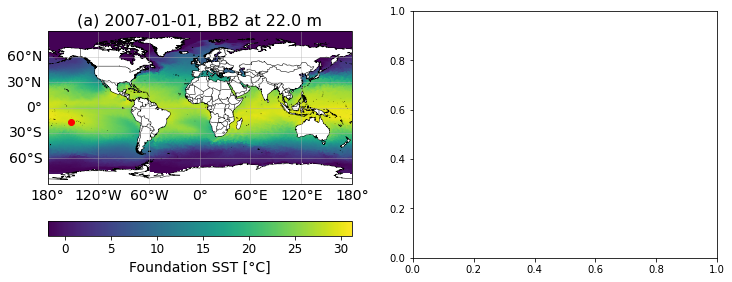

In [25]:
# Plot a map, the seasonal cycle and the full time series for SST.
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1,projection=crs)
plot_background(ax1)
pc1 = ax1.pcolormesh(lon_sst,lat_sst,l4_sst[0]-273.15,shading='nearest',transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(pc1, orientation = 'horizontal')
cbar1.ax.tick_params(labelsize=12) 
ax1.plot(lon0,lat0,'or')
ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
         [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
cbar1.set_label('Foundation SST [°C]',size=14)
ax1.set_title('(a) ' + str_start+', '+sf0+' at '+str(wd0)+' m', fontsize=16)

ax2 = fig.add_subplot(2,2,2)
#ax2.plot(np.arange(1,13),sst_seasonal_cycle-273.15,'o-')
sst_years = sst_t.reshape((nyears,12))
sst_mean_seasonal = np.mean(sst_years,axis=0)-273.15; print(sst_mean_seasonal)
sst_std_seasonal = np.std(sst_years,axis=0); print(sst_std_seasonal)
ax2.errorbar(np.arange(1,13),sst_mean_seasonal,sst_std_seasonal,'o-')
ax2.tick_params(axis='both',labelsize=14)
ax2.set_title('(b) Foundation SST seasonal cycle [°C]', fontsize=16)
ax2.set_xlabel('Month',fontsize=14)
ax2.set_xticks(np.arange(1,13))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.grid()

ax3 = fig.add_subplot(2,1,2)
ax3.plot(time_series,sst_t-273.15,'o-')
ax3.tick_params(axis='both',labelsize=14)
ax3.set_ylabel('Foundation SST [°C]',fontsize=14)
ax3.set_xlabel('Time',fontsize=14)
ax3.set_xticks(np.arange(0,len(sst_series),12))
ax3.set_xticklabels(time_series[::12])
ax3.set_title('(c) Time series', fontsize=16)
plt.grid()
ax3.hlines(sst_max-273.15,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(sst_min-273.15,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(sst_avg-273.15,time_series[0],time_series[-1],colors='k',linestyles='solid')

figure_name = 'map_time_series_sst_'+sf0+'_'+str(wd0)+'.png'
plt.savefig(figure_name,bbox_inches='tight')

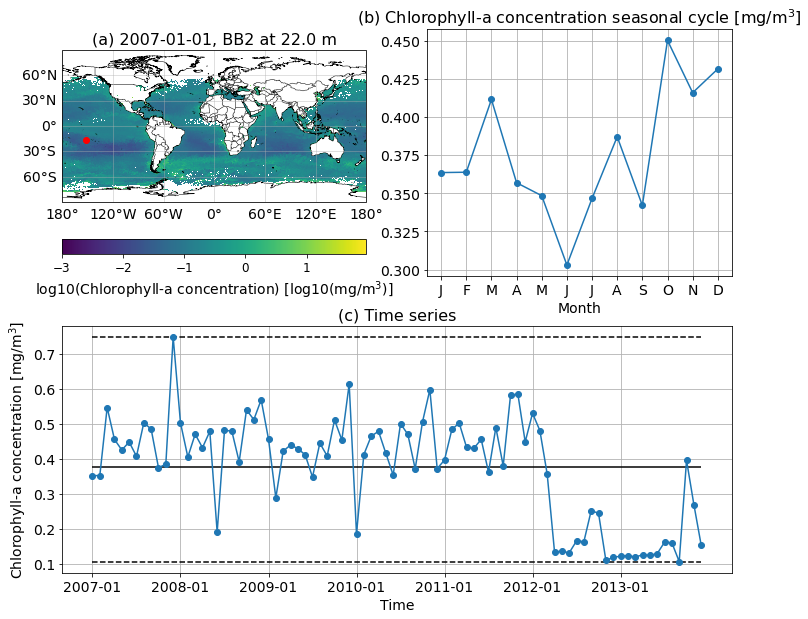

In [8]:
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1,projection=crs)
plot_background(ax1)
pc1 = ax1.pcolormesh(lon_chla,lat_chla,np.log10(chla_map[0]),shading='nearest',transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(pc1, orientation = 'horizontal')
cbar1.ax.tick_params(labelsize=12) 
ax1.plot(lon0,lat0,'or')
ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
         [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
cbar1.set_label('log10(Chlorophyll-a concentration) [log10(mg/m$^3$)]',size=14)
ax1.set_title('(a) ' + str_start+', '+sf0+' at '+str(wd0)+' m', fontsize=16)

ax2 = fig.add_subplot(2,2,2)
ax2.plot(np.arange(1,13),chla_seasonal_cycle,'o-')
ax2.tick_params(axis='both',labelsize=14)
ax2.set_title('(b) Chlorophyll-a concentration seasonal cycle [mg/m$^3$]', fontsize=16)
ax2.set_xlabel('Month',fontsize=14)
ax2.set_xticks(np.arange(1,13))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.grid()

ax3 = fig.add_subplot(2,1,2)
ax3.plot(time_series,chla_t,'o-')
ax3.tick_params(axis='both',labelsize=14)
ax3.set_ylabel('Chlorophyll-a concentration [mg/m$^3$]',fontsize=14)
ax3.set_xlabel('Time',fontsize=14)
ax3.set_xticks(np.arange(0,len(sst_series),12))
ax3.set_xticklabels(time_series[::12])
ax3.set_title('(c) Time series', fontsize=16)
plt.grid()
ax3.hlines(chla_max,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(chla_min,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(chla_avg,time_series[0],time_series[-1],colors='k',linestyles='solid')

figure_name = 'map_time_series_chla_'+sf0+'_'+str(wd0)+'.png'
plt.savefig(figure_name,bbox_inches='tight')

In [21]:
print(nyears)

7


<ErrorbarContainer object of 3 artists>

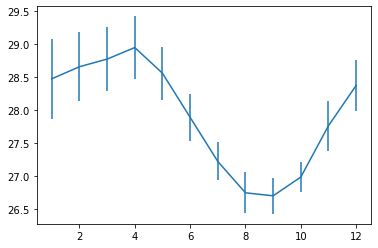

In [22]:
a = sst_t.reshape((nyears,12))
sst_mean_seasonal = np.mean(a,axis=0)-273.15
sst_std_seasonal = np.std(a,axis=0)
plt.errorbar(np.arange(1,13),sst_mean_seasonal,sst_std_seasonal)

In [59]:
# Set the path to SST files
path2sst = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/'
#path2chla

# Set the time window in which data are available
str_start = '2010-12-01' #'YYYY-MM-DD'
str_end = '2010-12-31'

In [24]:
# Set the half width of the box over which to take the average.
dlat = 0.1
dlon = 0.1

# Select the point.
lon0 = df_loc['LONG'][0]
lat0 = df_loc['LAT'][0]

# Time loop
instant_start = np.datetime64(str_start)
instant_end = np.datetime64(str_end)
instant = instant_start
it_s_the_first_instant = True
sst_series = []

while instant <= instant_end:
    print(instant)
    pd_instant = pd.to_datetime(instant)
    year_oi = str(pd_instant.year).zfill(4)
    month_oi = str(pd_instant.month).zfill(2)
    day_oi = str(pd_instant.day).zfill(2)

    # Set the path to the SST data. For a given day, read the L4 daily map over the area of interest.
    path_sst_oi = path2sst + '/' +  year_oi + '/' + month_oi + '/' + day_oi + '/'
    filename_sst = sorted(glob(path_sst_oi + '*2.1-v*')) # this removes the file with the 'anomaly' in their name.
    ds_sst = xr.open_dataset(filename_sst[0])

    sst0 = ds_sst['analysed_sst'].sel(lon=slice(lon0-dlon,lon0+dlon),
                                      lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

    if it_s_the_first_instant:
        # Check the position of the point on a map.
        crs = ccrs.PlateCarree()
        lon_sst = ds_sst['lon'].values
        lat_sst = ds_sst['lat'].values
        l4_sst = ds_sst['analysed_sst'].values
        
        fig = plt.figure(figsize=(20,14))

        ax1 = fig.add_subplot(2, 1, 1, projection=crs)
        plot_background(ax1)
        pc1 = ax1.pcolormesh(lon_sst,lat_sst,l4_sst[0]-273.15,shading='nearest',transform=ccrs.PlateCarree())
        cbar1 = plt.colorbar(pc1)
        cbar1.ax.tick_params(labelsize=12) 
        ax1.plot(lon0,lat0,'or')
        ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
                 [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
        cbar1.set_label('Depth SST [°C]',size=14)
        ax1.set_title(year_oi + '-' + month_oi + '-' + day_oi, fontsize=16)
        
        it_s_the_first_instant = False
    
    print(sst0)
    print(sst0.dtype)
    sst_series.extend(sst0)
    instant += np.timedelta64(1,'D')
        

2007-01-01
[302.252]
float32
2007-01-02
[302.15134]
float32
2007-01-03
[302.158]
float32
2007-01-04
[302.16534]
float32
2007-01-05
[302.23065]
float32
2007-01-06
[302.21]
float32
2007-01-07
[302.1733]
float32
2007-01-08
[302.128]
float32
2007-01-09
[302.16064]
float32
2007-01-10
[302.24265]
float32
2007-01-11
[302.17596]
float32
2007-01-12
[302.06198]
float32
2007-01-13
[302.07468]
float32
2007-01-14
[301.8033]
float32
2007-01-15
[301.7547]
float32
2007-01-16
[301.62534]
float32
2007-01-17
[301.49734]
float32
2007-01-18
[301.45203]
float32
2007-01-19
[301.52597]
float32
2007-01-20
[301.53333]
float32
2007-01-21
[301.622]
float32
2007-01-22
[301.59402]
float32
2007-01-23
[301.46335]
float32
2007-01-24
[301.52597]
float32
2007-01-25
[301.45]
float32
2007-01-26
[301.53333]
float32
2007-01-27
[301.764]
float32
2007-01-28
[301.68536]
float32
2007-01-29
[301.68997]
float32
2007-01-30
[301.67932]
float32
2007-01-31
[301.86465]
float32
2007-02-01
[301.87735]
float32
2007-02-02
[301.86133]
floa

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f3b4c1643a0> (for post_execute):


KeyboardInterrupt: 

302.7444


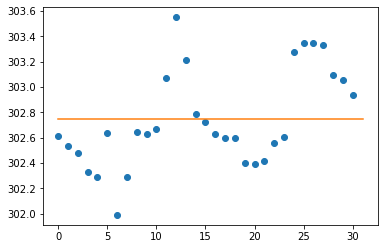

In [50]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# JAN

302.23093


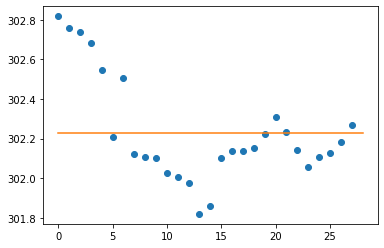

In [58]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# FEB

301.2399


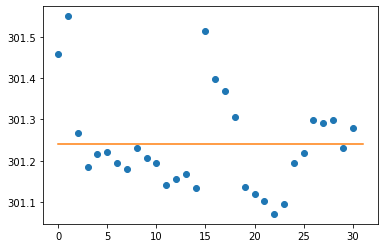

In [61]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# DEC

In [54]:
monthly_file = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/2010/prova.nc'
ds_m = xr.open_dataset(monthly_file)
sst0 = ds_m['analysed_sst'].sel(lon=slice(lon0-dlon,lon0+dlon),
                                lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

print(sst0)

[302.7433  302.23    302.26602 302.47733 302.18002 301.3493  300.58066
 300.11133 299.81732 300.1327  300.9153  301.23996]
